# Introduction

You should have a database created from pasing one of the zip files hosted by HHS.



In [1]:
from sqlalchemy import engine_from_config, func
from sqlalchemy.orm import sessionmaker
from hornstone.alchemy import Base
import us
from datetime import timedelta, date

from revaers.models import Data, VaxData
from revaers.parser import parse_csv
from revaers.parser import parse_csvfile
from revaers.parser import parse_vaxfile

import numpy as np
import plotly.io as pio
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf

plt.style.use('dark_background')
one_day = timedelta(days=1)
today = date.today()
enddate = date(2021, 1, 1)


In [2]:

dburl = 'postgresql+psycopg2://dbadmin@localhost/revaers'
settings = {'sqlalchemy.url': dburl}
engine = engine_from_config(settings)
Base.metadata.create_all(engine)
Session = sessionmaker()
Session.configure(bind=engine)


In [3]:
s = Session()

def make_cvquery(session, enddate):
    query = session.query(Data, VaxData).join(VaxData)
    query = query.filter(VaxData.vax_type == 'COVID19')
    query = query.filter(Data.recvdate <= enddate)
    return query

def get_vax_manus(session, enddate):
    query = make_cvquery(session, enddate)
    query = query.distinct(VaxData.vax_manu).group_by(VaxData.vax_manu,
                                                      Data.vaers_id,
                                                      VaxData.vaers_id)
    return [r.VaxData.vax_manu for r in query]


def get_vtype_counts(session, enddate):
    vtypes = get_vax_manus(session, enddate)
    counts = dict()
    for manu in vtypes:
        query = make_cvquery(session, enddate)
        query = query.filter(VaxData.vax_manu == manu)
        counts[manu] = query.count()
    return counts

In [4]:
s.query(Data).count()


218082

In [5]:

def make_data_frame(query):
    return pd.read_sql(query.statement, query.session.bind)


<BarContainer object of 3 artists>

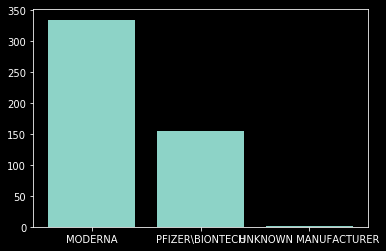

In [6]:
c = get_vtype_counts(s, enddate)
c.keys()
c.values()
plt.bar(c.keys(), c.values())


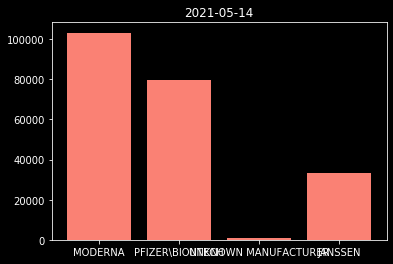

{'JANSSEN': 33383, 'MODERNA': 103221, 'PFIZER\\BIONTECH': 79772, 'UNKNOWN MANUFACTURER': 714}


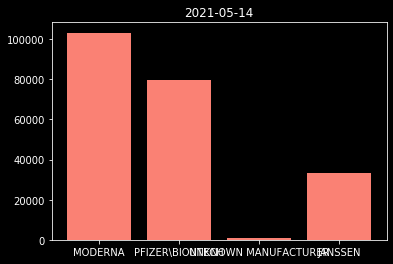

In [14]:
from IPython.display import display, clear_output

fig, ax = plt.subplots()

index_date = enddate
last_report_date = s.query(func.max(Data.recvdate)).one()[0]
while index_date <= last_report_date:
    counts = get_vtype_counts(s, index_date)
    clear_output(wait=True)
    ax.bar(counts.keys(), counts.values())
    ax.set_title(index_date)
    display(fig)
    print(counts)
    index_date += one_day

In [16]:
plt.show()
index_date

datetime.date(2021, 5, 15)

In [17]:
q = s.query(func.count(Data.vaers_id).label('Events'), Data.csvdate).group_by(Data.csvdate).order_by(Data.csvdate) 

In [18]:
df = make_data_frame(q)

In [19]:
df.set_index(df.csvdate)

,Events,csvdate
csvdate,,
2021-02-19,5351,2021-02-19
2021-02-26,3958,2021-02-26
2021-03-12,11309,2021-03-12
2021-03-19,7389,2021-03-19
2021-03-26,6180,2021-03-26
2021-04-02,6266,2021-04-02
2021-04-09,5826,2021-04-09
2021-04-16,11495,2021-04-16
2021-04-23,17743,2021-04-23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Events   13 non-null     int64 
 1   csvdate  13 non-null     object
dtypes: int64(1), object(1)
memory usage: 336.0+ bytes


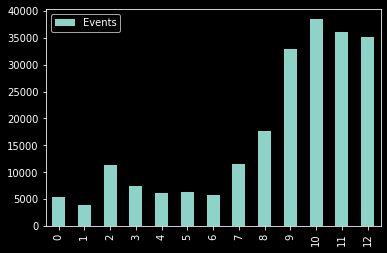

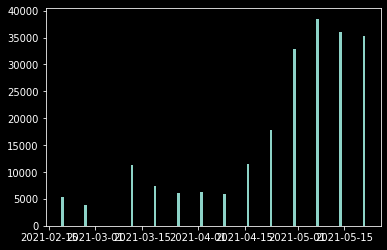

In [34]:
df.plot.bar()
bardata = dict()
for result in q:
    bardata[result.csvdate] = result.Events
    
bardata
fig, ax = plt.subplots()

ax.bar(bardata.keys(), bardata.values())
#ax.legend()
df.info()

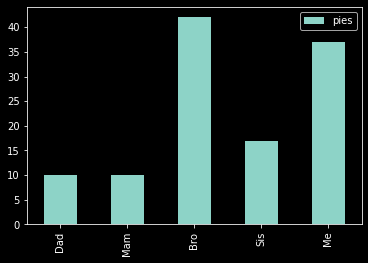

In [29]:
plotdata = pd.DataFrame(
    {"pies": [10, 10, 42, 17, 37]}, 
    index=["Dad", "Mam", "Bro", "Sis", "Me"])
# Plot a bar chart
plotdata.plot(kind="bar")

In [37]:
q = make_cvquery(s, today) 
df = make_data_frame(q)
df

,vaers_id,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,died,...,questionable,csvdate,vaers_id,vax_type,vax_manu,vax_lot,vax_dose_series,vax_route,vax_site,vax_name
0,1316044,2021-05-14,NY,66.0,NaN,,M,None,"tested positive for COVID-19 with fever, chill...",False,...,False,2021-05-21,1316044,COVID19,PFIZER\BIONTECH,EL9269,2,,RA,COVID19 (COVID19 (PFIZER-BIONTECH))
1,1316045,2021-05-14,,NaN,NaN,,F,None,pain was horrible; bumps on the back of her ne...,False,...,False,2021-05-21,1316045,COVID19,PFIZER\BIONTECH,,1,,,COVID19 (COVID19 (PFIZER-BIONTECH))
2,1316052,2021-05-14,FL,NaN,NaN,,F,None,was exposed to someone who was positive for CO...,False,...,False,2021-05-21,1316052,COVID19,PFIZER\BIONTECH,,1,,,COVID19 (COVID19 (PFIZER-BIONTECH))
3,1316055,2021-05-14,,NaN,NaN,,U,None,had their first Pfizer vaccine 2 weeks ago and...,False,...,False,2021-05-21,1316055,COVID19,PFIZER\BIONTECH,,1,,,COVID19 (COVID19 (PFIZER-BIONTECH))
4,1316136,2021-05-14,,NaN,NaN,,M,None,This is a spontaneous report from a contactabl...,False,...,False,2021-05-21,1316136,COVID19,PFIZER\BIONTECH,,UNK,,,COVID19 (COVID19 (PFIZER-BIONTECH))
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217085,1315834,2021-05-13,FL,NaN,77.0,,F,None,had two very large blood cloths moved from her...,False,...,False,2021-05-21,1315834,COVID19,MODERNA,,1,OT,LA,COVID19 (COVID19 (MODERNA))
217086,1315857,2021-05-13,CA,46.0,46.0,,F,None,Shortness of breath Extreme headache/pressure,False,...,False,2021-05-21,1315857,COVID19,JANSSEN,1808982,1,SYR,LA,COVID19 (COVID19 (JANSSEN))
217087,1315866,2021-05-13,NJ,24.0,24.0,,F,None,"Major fatigue, light headed/dizziness, missed ...",False,...,False,2021-05-21,1315866,COVID19,JANSSEN,NA,1,IM,LA,COVID19 (COVID19 (JANSSEN))
217088,1315878,2021-05-13,CO,NaN,NaN,,U,None,2 episodes of pass out whom got the second dos...,False,...,False,2021-05-21,1315878,COVID19,MODERNA,008C21A,1,OT,,COVID19 (COVID19 (MODERNA))


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217090 entries, 0 to 217089
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   vaers_id         217090 non-null  int64  
 1   recvdate         217090 non-null  object 
 2   state            217090 non-null  object 
 3   age_yrs          199996 non-null  float64
 4   cage_yr          183320 non-null  float64
 5   cage_mo          217090 non-null  object 
 6   sex              217090 non-null  object 
 7   rpt_date         122 non-null     object 
 8   symptom_text     217090 non-null  object 
 9   died             217090 non-null  bool   
 10  datedied         3807 non-null    object 
 11  l_threat         217090 non-null  object 
 12  er_visit         217090 non-null  object 
 13  hospital         217090 non-null  object 
 14  hospdays         217090 non-null  object 
 15  x_stay           217090 non-null  object 
 16  disable          217090 non-null  obje